## Convolutional Neural Network

In [43]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader

In [44]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [45]:
len(train_data), len(test_data)

(60000, 10000)

In [46]:
image, label = train_data[0]

print(image.shape, label)

torch.Size([1, 28, 28]) 9


In [81]:
class_names = train_data.classes
class_name_with_label = train_data.class_to_idx

class_names, class_name_with_label

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

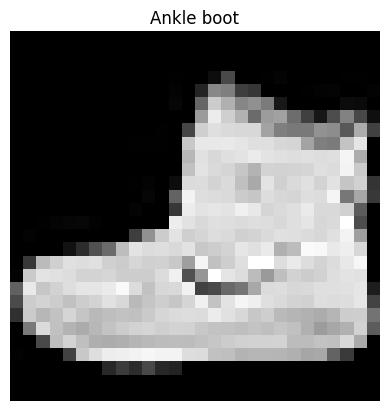

In [48]:
# visualize

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("off")
plt.show()

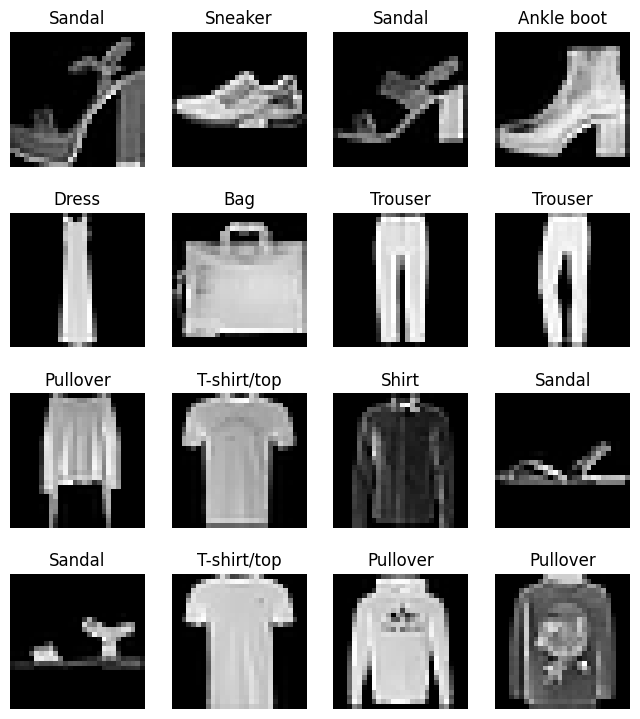

In [49]:
fig = plt.figure(figsize=(8,9))
rows, cols = 4, 4

for i in range(1, rows*cols + 1):
  random_index = torch.randint(0, len(train_data), size=[1]).item()

  image, label = train_data[random_index]
  fig.add_subplot(rows, cols, i)

  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis("off")

plt.show()

In [50]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [51]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [52]:
print(f"DataLoader: {train_dataloader}")
print(f"Length of train dataloader {len(train_dataloader)} batches of 32")

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f928fa83580>
Length of train dataloader 1875 batches of 32


In [53]:
print(f"DataLoader: {test_dataloader}\n")
print(f"Length of test dataloader {len(test_dataloader)} batches of 32")

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f928fa80250>

Length of test dataloader 313 batches of 32


In [54]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Building a CNN model:

In [55]:
class CNNModelV0(nn.Module):
  """
  Model architecture of Tiny VGG
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    # conv layer 1
    self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels= input_shape,
                                                out_channels=hidden_units,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=hidden_units,
                                                out_channels=hidden_units,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2))
    # conv layer 2
    self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                                out_channels=hidden_units,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=hidden_units,
                                                out_channels=hidden_units,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2))
    # classifier layer
    self.classifier = nn.Sequential(nn.Flatten(),
                                    # out of previous conv2d : 10, 7, 7
                                    # after flatten: 10*7*7 = 490
                                    nn.Linear(in_features=10 * 7 * 7,
                                              out_features=output_shape))
  def forward(self, x):
    x = self.conv_block_1(x)
    # print("shape from conv layer 1 ", x.shape)
    x = self.conv_block_2(x)
    # print("shape from conv layer 2 ", x.shape)
    x = self.classifier(x)
    # print("shape from classifier layer ", x.shape)
    return x

In [56]:
tensor_image = torch.rand(size=(1, 28, 28))
tensor_image.shape

torch.Size([1, 28, 28])

In [57]:
# model_0(tensor_image.unsqueeze(0))

# from conv layer 1  torch.Size([1, 10, 14, 14])
# shape from conv layer 2  torch.Size([1, 10, 7, 7])
# ---------------------------------------------------------------------------
# RuntimeError                              Traceback (most recent call last)
# <ipython-input-51-a116bd79e24e> in <cell line: 1>()
# ----> 1 model_0(tensor_image.unsqueeze(0))

# 8 frames
# /usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py in forward(self, input)
#     115
#     116     def forward(self, input: Tensor) -> Tensor:
# --> 117         return F.linear(input, self.weight, self.bias)
#     118
#     119     def extra_repr(self) -> str:

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x490 and 0x10)

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [59]:
model_0 = CNNModelV0(input_shape=1, # for grayscale , 3 for rgb
                     hidden_units=10,
                     output_shape=len(class_names)).to(device)
model_0

CNNModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [60]:
# after shape correction in linear layer after flatten
model_0(tensor_image.unsqueeze(0))

tensor([[ 0.0204,  0.0345, -0.0198, -0.0179,  0.0069,  0.0302,  0.0048, -0.0296,
         -0.0550, -0.0117]], grad_fn=<AddmmBackward0>)

In [61]:
dummy = torch.rand(size=(32,3,28,28)).to(device)
test_dummy_image = dummy[0]

print(test_dummy_image.shape)

torch.Size([3, 28, 28])


In [62]:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=5,
                       stride=1,
                       padding=0)

out_conv_layer = conv_layer(dummy)
print(out_conv_layer.shape)

torch.Size([32, 10, 24, 24])


In [63]:
image_show = test_dummy_image.permute(1,2,0)
image_show.shape

torch.Size([28, 28, 3])

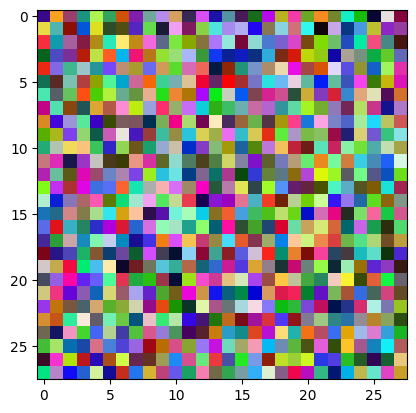

In [64]:
plt.imshow(image_show)

In [65]:
print(f"Test image original shape: {test_dummy_image.shape}")

Test image original shape: torch.Size([3, 28, 28])


In [66]:
print(f"Test image with unsqueezed dim: {test_dummy_image.unsqueeze(dim=0).shape}")

Test image with unsqueezed dim: torch.Size([1, 3, 28, 28])


In [67]:
test_dummy_image_conv_out = conv_layer(test_dummy_image.unsqueeze(dim=0))
print(f"After conv: {test_dummy_image_conv_out.shape}")

After conv: torch.Size([1, 10, 24, 24])


In [68]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

In [69]:
test_dummy_image_max_pool_out = max_pool_layer(test_dummy_image_conv_out)
print(f"After max pool: {test_dummy_image_max_pool_out.shape}")

After max pool: torch.Size([1, 10, 12, 12])


In [70]:
another_dummy_image = torch.randn(size=(1,1,2,2))
# very small image shape
max_pool = nn.MaxPool2d(2)

max_pool_tensor = max_pool(another_dummy_image)
print("Max pool tensor: ",max_pool_tensor)
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Max pool tensor:  tensor([[[[2.1726]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


## Training CNN Model_0

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [72]:
import requests

helper_content = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

with open("helper_functions.py", "wb") as f:
  f.write(helper_content.content)

In [73]:
from helper_functions import accuracy_fn

In [74]:
epochs = 3

for epoch in range(epochs):
  print(f"Epoch: {epoch}\n---------")
  train_loss = 0
  train_acc = 0
  model_0.train()
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)

    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

  # testing
  model_0.eval()
  with torch.inference_mode():
    test_loss = 0
    test_acc = 0
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model_0(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.58199 | Train acc: 79.18%
Test loss: 0.39788 | Test acc: 85.52%

Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.33638 | Train acc: 87.91%
Test loss: 0.32638 | Test acc: 88.46%

Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.29745 | Train acc: 89.29%
Test loss: 0.29890 | Test acc: 89.09%



## Making Prediction

In [75]:
def prediction(model: torch.nn.Module,
               data: list,
               device: torch.device = device):
  pred_probs = []
  model.eval()

  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      # forward propagation
      pred_logit = model(sample)

      # get pred prob
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # get pred prob in cpu if in gpu
      pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [76]:
import random

random.sample([1,2,3,4,5,6,7,8,9,0], k=2)

[0, 5]

In [95]:
test_samples = []
test_labels = []


for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# view
test_samples[0].shape, test_labels[0]

(torch.Size([1, 28, 28]), 3)

In [96]:
for image in test_samples:
  pred_probability = prediction(model_0,
             data=test_samples)

# converting to labels from probability
pred_class = pred_probability.argmax(dim=1)
pred_class

tensor([3, 1, 1, 2, 1, 2, 6, 7, 9])

In [97]:
test_labels

[3, 1, 1, 2, 1, 2, 6, 9, 9]

In [98]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

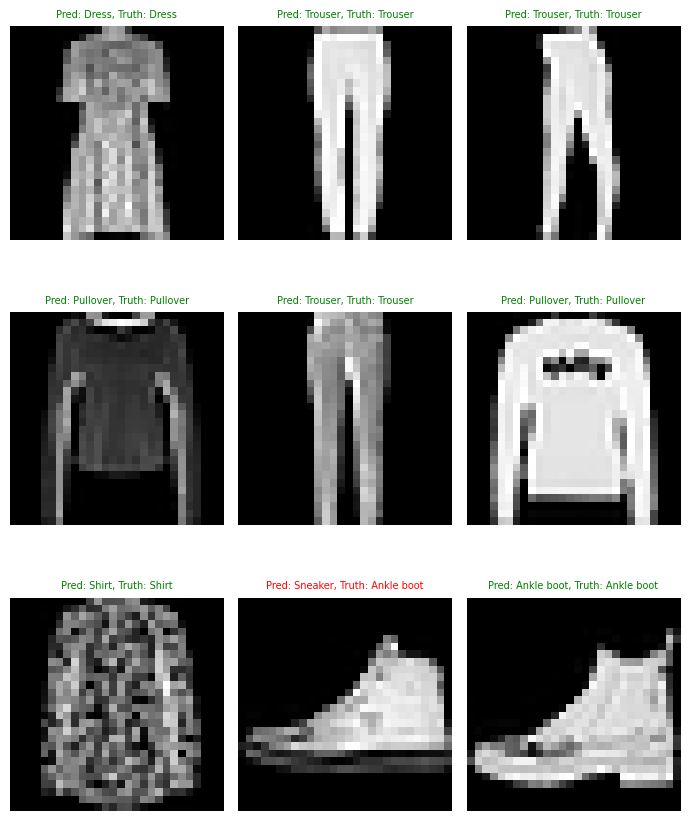

In [99]:
from operator import truth
plt.figure(figsize=(7,9))
nrows, ncols = 3, 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_class[i]]
  truth_label = class_names[test_labels[i]]
  title = f"Pred: {pred_label}, Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title, fontsize=7, color="green")
  else:
    plt.title(title, fontsize=7, color="red")
  plt.axis("off")

plt.tight_layout()
plt.show()

In [100]:
## Confusion matrix

y_preds = []
model_0.eval()

with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_logit = model_0(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())


y_pred_tensor = torch.cat(y_preds)
y_pred_tensor.shape

torch.Size([10000])

In [101]:
y_pred_tensor[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [103]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 12.7 MB/s eta 0:00:00


In [104]:
!pip install mlxtend

In [106]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [111]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

print(confmat_tensor.shape)

torch.Size([10, 10])


In [112]:
confmat_tensor

tensor([[628,   7,  31,  71,  17,   0, 239,   0,   7,   0],
        [  3, 894,   0,  80,  15,   0,   6,   0,   2,   0],
        [ 13,   2, 717,  25, 142,   0,  96,   0,   5,   0],
        [ 19,  10,  11, 895,  20,   0,  39,   0,   6,   0],
        [  7,   3,  64,  66, 766,   0,  84,   0,  10,   0],
        [  2,   1,   0,   8,   1, 776,  11,  85,  98,  18],
        [ 71,   5,  79,  65,  88,   0, 678,   0,  14,   0],
        [  1,   0,   0,   1,   0,  17,   0, 934,   9,  38],
        [  9,   2,   0,  19,   8,  10,  21,   9, 921,   1],
        [  0,   0,   0,   3,   1,  32,  14, 113,  18, 819]])

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

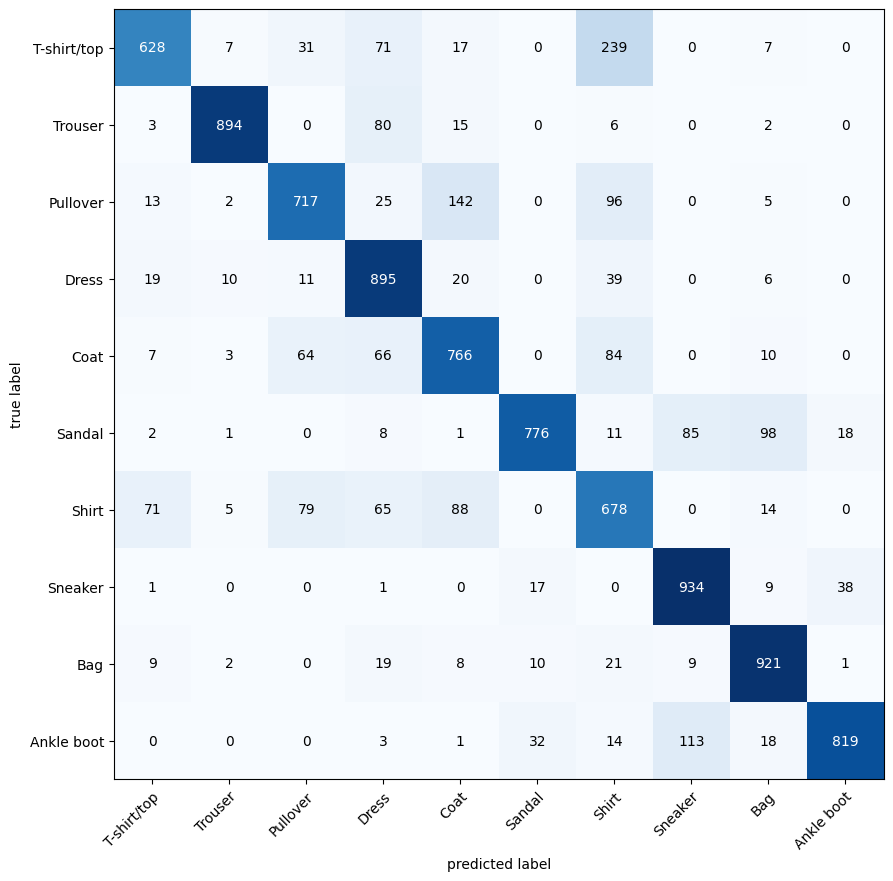

In [113]:
plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                     figsize=(10,10),
                     class_names=class_names)

In [115]:
model_name = "cnn_model.pt"
save_path = "./"

torch.save(obj=model_0.state_dict(),
           f=f"{save_path}/{model_name}")


In [116]:
loaded_cnn_model = torch.load(f=f"{save_path}/{model_name}")
new_model_cnn = CNNModelV0(input_shape=1,
                         hidden_units=10,
                         output_shape=len(class_names)).to(device)
new_model_cnn.load_state_dict(loaded_cnn_model)

<ipython-input-116-1a29f250dfd8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_cnn_model = torch.load(f=f"{save_path}/{model_name}")


<All keys matched successfully>

In [117]:
new_model_cnn

CNNModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)